In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gas_data = pd.read_csv(
    "RegGas_wk_data.csv",                           # path
    header=0,                                       # the row with the old names
    names=["date", "price"],                        # new column names
    parse_dates=["date"],                           # parse to datetime
    index_col="date"                                # set index
)
gas_data["price"] = gas_data["price"].astype("float64")

# Accounts for data latency issues (date index shifted up by 1)
cpi_data = pd.read_csv(
    "CPI_data.csv",
    header=0,
    names=["date", "cpi"],
    parse_dates=["date"],
    index_col="date"
)

# Align CPI to gas data dates (monthly -> weekly forward fill)
gas_data = gas_data.merge(
    cpi_data,
    left_on=[gas_data.index.year, gas_data.index.month],
    right_on=[cpi_data.index.year, cpi_data.index.month],
    how="left"
).set_index(gas_data.index)
gas_data.pop("key_0")
gas_data.pop("key_1")
gas_data["cpi"].ffill(inplace=True) # for the last few values

# Normalizing for inflation
gas_data["price"] = gas_data["price"]*(gas_data["cpi"][-1]/gas_data["cpi"])

# Log prices since forces model predictions to be +ve
gas_data["lprice"] = np.log(gas_data["price"])

gas_data.tail(10)

/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_29611/3130930427.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gas_data = pd.read_csv(
/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_29611/3130930427.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cpi_data = pd.read_csv(
/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_29611/3130930427.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

,price,cpi,lprice
date,,,
2025-08-25,3.164067,323.048,1.151858
2025-09-01,3.185080,323.976,1.158478
2025-09-08,3.200119,323.976,1.163188
2025-09-15,3.176057,323.976,1.155641
2025-09-22,3.181070,323.976,1.157218
2025-09-29,3.125930,323.976,1.139732
2025-10-06,3.124000,324.800,1.139114
2025-10-13,3.061000,324.800,1.118742
2025-10-20,3.019000,324.800,1.104926


In [7]:
### EXOGENOUS REGRESSORS ###

## RBOB Futures, WTI Crude Futures, Crack Spread:

futures_data = pd.read_csv(
    "NYMEX_Futures_data.csv",
    header=0,
    names=["date", "RBOB_F", "WTI_F"],
    parse_dates=["date"],
    index_col="date"
)

# Resample to weekly (every monday)
futures_data = futures_data.resample("W-MON").mean()

# Units standardization. WTI reported in $/barrel and RBOB reported in $/gal. 1 barrel = 42 gal.
futures_data["WTI_F"] = futures_data["WTI_F"]/42

# Inflation adjustments
exog_data = futures_data.merge(
    cpi_data,
    left_on=[futures_data.index.year, futures_data.index.month],
    right_on=[cpi_data.index.year, cpi_data.index.month],
    how="left"
).set_index(futures_data.index)
exog_data.pop("key_0")
exog_data.pop("key_1")
exog_data["cpi"].ffill(inplace=True)
exog_data["RBOB_F"] = exog_data["RBOB_F"]*(exog_data["cpi"][-1]/exog_data["cpi"])
exog_data["WTI_F"] = exog_data["WTI_F"]*(exog_data["cpi"][-1]/exog_data["cpi"])

# Calculate RBOB/WTI Crack Spread
exog_data["crack_spread"] = exog_data["RBOB_F"] - exog_data["WTI_F"]

# Geo-Political Risk Indicator
gpr_data = pd.read_csv(
    "GPR_dly_data.csv",
    header=0,
    names=["date", "GPR"],
    parse_dates=["date"],
    index_col="date"
)
# Resample to weekly (every monday)
gpr_data = gpr_data.resample("W-MON").mean()
gpr_data["GPR_z"] = (gpr_data["GPR"] - gpr_data["GPR"].mean()) / gpr_data["GPR"].std()

exog_data = exog_data.merge(
    gpr_data,
    on="date",
    how="left"
).set_index(exog_data.index)
exog_data.tail(10)

/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_29611/1141262555.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  futures_data = pd.read_csv(
/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_29611/1141262555.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  exog_data["cpi"].ffill(inplace=True)
/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_29611/11412

,RBOB_F,WTI_F,cpi,crack_spread,GPR,GPR_z
date,,,,,,
2025-08-25,2.148188,1.520296,323.048,0.627892,117.748571,0.293195
2025-09-01,2.170005,1.527745,323.976,0.642260,133.818571,0.593582
2025-09-08,2.002681,1.514175,323.976,0.488506,120.074286,0.336668
2025-09-15,2.000475,1.502192,323.976,0.498283,128.915714,0.501936
2025-09-22,2.011303,1.515559,323.976,0.495743,124.168571,0.413200
2025-09-29,2.015714,1.539859,323.976,0.475855,116.240000,0.264996
2025-10-06,1.894400,1.462857,324.800,0.431543,197.910000,1.791607
2025-10-13,1.870200,1.448476,324.800,0.421724,170.224286,1.274094
2025-10-20,1.828600,1.378524,324.800,0.450076,172.871429,1.323575


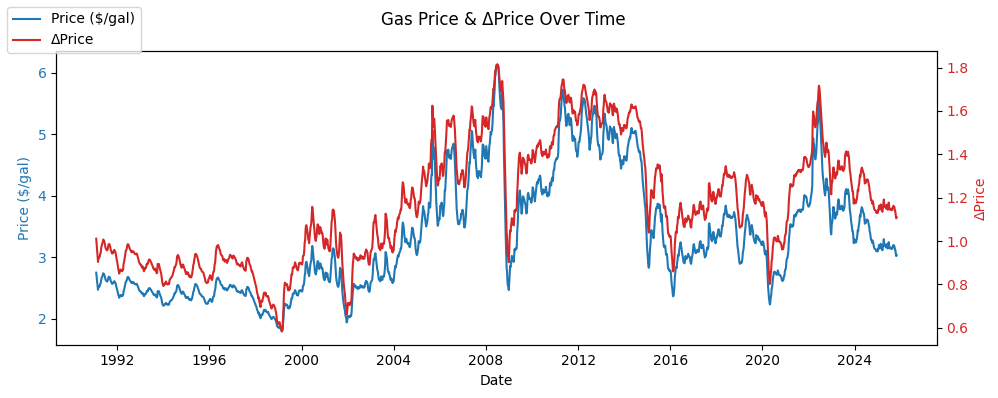

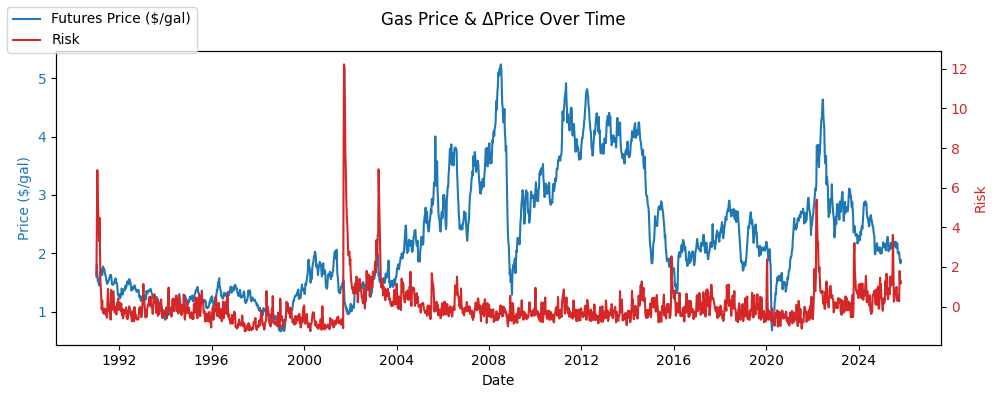

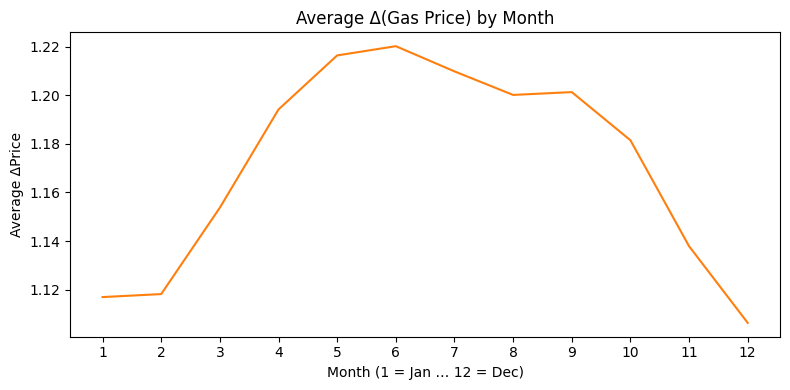

In [11]:
# Full time-series line chart
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(gas_data.index, gas_data["price"], color="tab:blue", label="Price ($/gal)")    # First axis for price
ax1.set_xlabel("Date")
ax1.set_ylabel("Price ($/gal)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.plot(gas_data.index, gas_data["lprice"], color="tab:red", label="ΔPrice")       # Second axis for ΔPrice
ax2.set_ylabel("ΔPrice", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
fig.suptitle("Gas Price & ΔPrice Over Time")
fig.legend(loc="upper left")
fig.tight_layout()

# Full time-series line chart
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(exog_data.index, exog_data["RBOB_F"], color="tab:blue", label="Futures Price ($/gal)")    # First axis for price
ax1.set_xlabel("Date")
ax1.set_ylabel("Price ($/gal)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.plot(exog_data.index, exog_data["GPR_z"], color="tab:red", label="Risk")       # Second axis for ΔPrice
ax2.set_ylabel("Risk", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
fig.suptitle("Gas Price & ΔPrice Over Time")
fig.legend(loc="upper left")
fig.tight_layout()

# Seasonal trend: average value per calendar month
monthly = gas_data.groupby(gas_data.index.month)[["price","lprice"]].mean()
fig, ax = plt.subplots(figsize=(8, 4))
monthly["lprice"].plot(ax=ax, color="tab:orange")
ax.set_title("Average Δ(Gas Price) by Month")
ax.set_xlabel("Month (1 = Jan … 12 = Dec)")
ax.set_ylabel("Average ΔPrice")
ax.set_xticks(range(1, 13))
plt.tight_layout()

Clearly seasonal where summer prices > winter prices

In [9]:
# Save to CSV
exog_data[["RBOB_F","WTI_F","crack_spread","GPR_z"]].to_csv("Exog_data.csv")
gas_data[["price","lprice","cpi"]].to_csv("RegGas_wk_data(Adj).csv")